In [1]:
import sys
sys.path.append('/root/autodl-tmp/I-AM/project/backend/agents')

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode

from typing import TypedDict, Annotated, Literal, NotRequired, List, Optional, Any
from pydantic import BaseModel, Field, ConfigDict, field_validator


import uuid
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."

tools = [get_weather]
tool_node = ToolNode(tools)

In [4]:
llm = ChatOpenAI(model="deepseek-chat", openai_api_key=os.getenv("DEEPSEEK_API_KEY"), openai_api_base='https://api.deepseek.com')

In [5]:

# class MainState(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

llm_with_tools = llm.bind_tools(tools)

def chat_bot(state: MessagesState):
    messages = state["messages"]
    res = llm_with_tools.invoke(messages)
    return {"messages": [res]}



In [12]:
tool_msg = {'messages': [HumanMessage(content="what's the weather in sf?", additional_kwargs={}, response_metadata={}, id='3fd4afca-0f4b-430b-aa1a-db4165f9f1c2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_edcc7ecb-5939-4ee5-9771-8606c9c98f59', 'function': {'arguments': '{"location":"San Francisco"}', 'name': 'get_weather'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 109, 'total_tokens': 129, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'prompt_cache_hit_tokens': 64, 'prompt_cache_miss_tokens': 45}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3a5770e1b4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bb19c383-4408-4a9d-82ce-b41a76c448da-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': 'call_0_edcc7ecb-5939-4ee5-9771-8606c9c98f59', 'type': 'tool_call'}], usage_metadata={'input_tokens': 109, 'output_tokens': 20, 'total_tokens': 129, 'input_token_details': {}, 'output_token_details': {}}), ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', id='3e81529b-7cf2-4859-b52f-86b2a171ad44', tool_call_id='call_0_edcc7ecb-5939-4ee5-9771-8606c9c98f59'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_d387ede2-193c-42b2-8449-ed75e0282135', 'function': {'arguments': '{"location": "San Francisco"}', 'name': 'get_weather'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 144, 'total_tokens': 164, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'prompt_cache_hit_tokens': 128, 'prompt_cache_miss_tokens': 16}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3a5770e1b4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cbf7094a-c2ea-4f91-ab95-d33b5d691e36-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': 'call_0_d387ede2-193c-42b2-8449-ed75e0282135', 'type': 'tool_call'}], usage_metadata={'input_tokens': 144, 'output_tokens': 20, 'total_tokens': 164, 'input_token_details': {}, 'output_token_details': {}}), ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', id='e60b934d-a525-4fc6-bdc8-f2df2b01100a', tool_call_id='call_0_d387ede2-193c-42b2-8449-ed75e0282135')]}
llm_with_tools.invoke(tool_msg['messages'])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_ecb0237d-3c20-47d6-b8f1-39c18190c16b', 'function': {'arguments': '{"location": "San Francisco"}', 'name': 'get_weather'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 179, 'total_tokens': 199, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'prompt_cache_hit_tokens': 128, 'prompt_cache_miss_tokens': 51}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3a5770e1b4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-50a21d1f-44c0-4ba9-ad27-31f028855a74-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': 'call_0_ecb0237d-3c20-47d6-b8f1-39c18190c16b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 179, 'output_tokens': 20, 'total_tokens': 199, 'input_token_details': {}, 'output_token_details': {}})

In [6]:
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    else:
       return END

chat_agent = StateGraph(MessagesState)
chat_agent.add_node("chat_bot", chat_bot)
chat_agent.add_node("tools", tool_node)

chat_agent.add_edge(START, "chat_bot")
chat_agent.add_conditional_edges(
    "chat_bot",
    should_continue,
    ["tools", END]
)

chat_agent.add_edge("tools", "chat_bot")

chat_agent = chat_agent.compile()

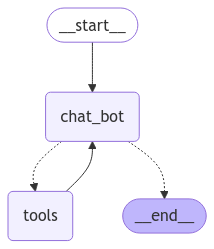

In [7]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(chat_agent.get_graph(xray=2).draw_mermaid_png()))

In [10]:
input = {"messages": [("human", "what's the weather in sf?")]}
for chunk in chat_agent.stream(input, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content="what's the weather in sf?", additional_kwargs={}, response_metadata={}, id='3fd4afca-0f4b-430b-aa1a-db4165f9f1c2')]}
{'messages': [HumanMessage(content="what's the weather in sf?", additional_kwargs={}, response_metadata={}, id='3fd4afca-0f4b-430b-aa1a-db4165f9f1c2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_edcc7ecb-5939-4ee5-9771-8606c9c98f59', 'function': {'arguments': '{"location":"San Francisco"}', 'name': 'get_weather'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 109, 'total_tokens': 129, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'prompt_cache_hit_tokens': 64, 'prompt_cache_miss_tokens': 45}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3a5770e1b4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bb19c383-4408-4a9d-82ce-b41a76c448da-0', tool_calls=[{'name': 'get_weather', 'args': {'loc

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT